# Training a normalizing flow

In this notebook, we use the API in `flowMC` to train two different normalizing flow networks to approximate a simple test distribution. The API is built on top of the companion libraries of Jax for deep learning, `flax` and `optax`. 

In typical applications of `flowMC` to obtain samples from a given posterior distribution you will not need to interact with this level of the API, the training will be directly handled within the sampling. However you will need to choose the normalizing flow model and this tutorial exemplifies the abilities of the two models currently available in the package.

We train both a RealNVP flow from [[Dinh et al. 2016]](https://arxiv.org/abs/1605.08803) and a more complex normalizing flow model, the rational quadratic spline model [[Durkan et al. 2019]](https://arxiv.org/abs/1906.04032).

In [1]:
import jax
import jax.numpy as jnp  # JAX NumPy
import jax.random as random  # JAX random
import optax  # Optimizers
import flax  # Deep Learning library for JAX
from flax.training import train_state  # Useful dataclass to keep train state

from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.nfmodel.utils import make_training_loop, sample_nf

We will use [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) from scikit-learn to create a toy dataset in 2-dimensions.

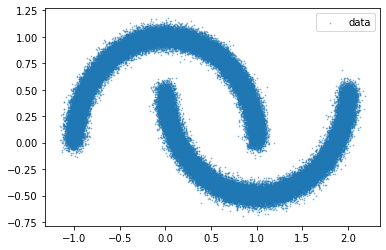

In [2]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

data = jnp.array(make_moons(n_samples=100000, noise=0.05)[0])

plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label='data')
plt.legend()


## RealNVPs 
We first use the RealNVP model to fit the data. We need to specify: 
- `n_layers`: the number of coupling layers. 
- `n_hidden`: the width of the hidden layers in the 1-hidden layer MLPs for learning the scales and translations in the affine coupling layers. 

Inflating these numbers provides more flexibility to the normalizing flow, yet at the cost of increasing the computational budget. 

In [3]:
# Model parameters
n_layers = 10
n_hidden = 100
n_dim = 2  # data dimension 

model = RealNVP(n_layers, n_dim, n_hidden)



# Use empirical mean and covariance to precondition the flow
rng_key, rng_subkey = jax.random.split(jax.random.PRNGKey(0), 2)
variables = model.init(rng_subkey, jnp.ones((1, 2)))["variables"]
variables = variables.unfreeze()
variables["base_mean"] = jnp.mean(data, axis=0)
variables["base_cov"] = jnp.cov(data.T)
variables = flax.core.freeze(variables)

Next, we initialize a `train_state` following `flax` logic and an `optax` optimizer beforw lanching the training. 

In [4]:
# Optimization parameters
num_epochs = 300
batch_size = 10000
learning_rate = 0.001
momentum = 0.9

key, rng_init, rng_train  = jax.random.split(rng_key, 3)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(rng_init, learning_rate, momentum)

train_flow, train_epoch, train_step = make_training_loop(model)

rng_train, state, loss_values = train_flow(
    rng_train, state, variables, data, num_epochs, batch_size
)

Training NF, current loss: 1.264: 100%|██████████| 300/300 [43:03<00:00,  8.61s/it]   


Text(0, 0.5, 'Loss')

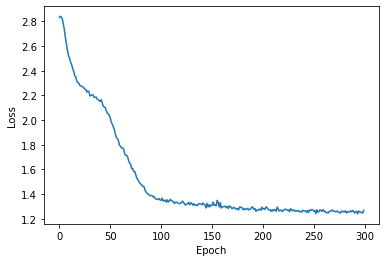

In [5]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Finally we can visualize what the flow has learned by comparing the data distribution to the distribution of samples from the flow.

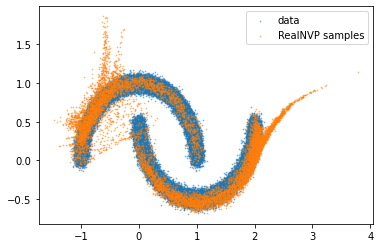

In [6]:
rng_key, rng_subkey = jax.random.split(rng_key, 2)
rng_subkey, nf_samples = sample_nf(model, state.params, rng_subkey, 10000, variables)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.scatter(nf_samples[:, 0], nf_samples[:, 1], s=0.5, alpha=0.5,
            label="RealNVP samples")
plt.legend()
plt.show()

## RQSplines
The second type of flows available are the RQSpline. These models are also based on coupling layers, however they allow for transformation more expressive than affine, namely splines of quotients of quadratic functions. Here the parameters are: 
- `n_layers`: the number of coupling layers. 
- `n_hidden`: the list of widths of the hidden layers MLPs for learning the polynomial coefficients.
-  `n_bins`: the number of bins for the spline decompositions.

As previsouly, the bigger these numbers the more flexibility to the normalizing flow and higher is the computational cost of one training iteration. While RQSplines are generally more computationally demanding per training step than RealNVPs, there can be a favorable trade-off in selecting this more sophisticated model as it may require less iterations to converge to a satisfactory solution. 

In [7]:

key, rng_model, rng_init, rng_train, rng_nf_sample = jax.random.split(
    jax.random.PRNGKey(0), 5
)

# Model parameters
n_layers = 8
n_hiddens = [64, 64]
n_bins = 8
n_dim = 2

model = RQSpline(n_dim, n_layers, n_hiddens, n_bins)

variables = model.init(rng_model, jnp.ones((1, 2)))["variables"]
variables = variables.unfreeze()
variables["base_mean"] = jnp.mean(data, axis=0)
variables["base_cov"] = jnp.cov(data.T)
variables = flax.core.freeze(variables)

def create_train_state(rng, learning_rate, momentum):
    params = model.init(rng, jnp.ones((1, 2)))["params"]
    tx = optax.adam(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

state = create_train_state(rng_init, learning_rate, momentum)

# Optimization parameters
num_epochs = 300
batch_size = 10000
learning_rate = 0.001
momentum = 0.9

train_flow, train_epoch, train_step = make_training_loop(model)
rng, state, loss_values = train_flow(
    rng_train, state, variables, data, num_epochs, batch_size
)

Training NF, current loss: 1.256: 100%|██████████| 300/300 [18:08<00:00,  3.63s/it]


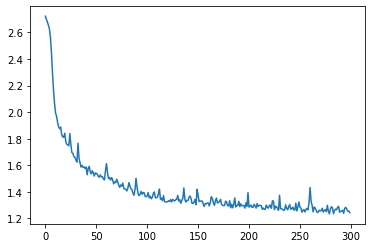

In [8]:
plt.plot(loss_values)

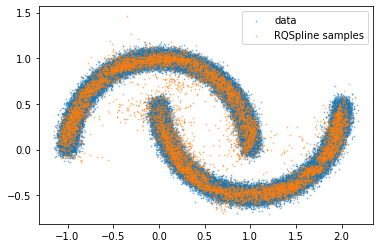

In [9]:
rng_key, nf_samples = sample_nf(model, state.params, rng_nf_sample, 10000, variables)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=0.5, alpha=0.5, label="data")
plt.scatter(nf_samples[:, 0], nf_samples[:, 1], s=0.5, alpha=0.5,
            label="RQSpline samples")
plt.legend()
plt.show()